# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from scipy import stats as st
import math as mth

import matplotlib.pyplot as plt

import requests
from urllib.parse import urlencode

# Описание проекта, цели и задачи

**Описание:**

Менеджер продукта банка обратил внимание на увеличение оттока клиентов.

**Цель:**
- провести анализ и выделить сегменты клиентов, которые более склонны к уходу;
- сформулировать возможные причины ухода;
- сформулировать рекомендации по сокращению оттока.

# Загрузка данных

In [3]:
# локальный файл

try:
    data = pd.read_csv('bank_dataset.csv')
    
    print('loaded from local source')
    
# Яндекс диск

except:
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = 'https://disk.yandex.ru/d/JVAJ9uxtV1uydQ'  

    # Получаем загрузочную ссылку
    
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    
    
    # Загружаем файл и сохраняем его
    
    data = pd.read_csv(download_url, encoding='UTF-8')
    
    print('loaded from web source')

loaded from local source


## Описание данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Колонки:**
- userid — идентификатор пользователя;
- score - баллы кредитного скоринга;
- City - город;
- Gender - пол;
- Age - возраст;
- Objects - количество объектов в собственности;
- Balance - баланс на счёте;
- Products - количество продуктов, которыми пользуется клиент;
- CreditCard - есть ли кредитная карта;
- Loyalty - активный клиент;
- estimated_salary - заработная плата клиента;
- Churn - ушёл или нет.

# Оценка качества данных, предобработка данных

In [5]:
data.head(1)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1


## Название столбцов

In [6]:
# приведем названия столбцов к нижнему регистру

data.columns = [col.lower() for col in data.columns]

In [7]:
# разделим названия столбцов из нескольких слов '_'

data = data.rename(columns={
                            'userid':'user_id',
                            'creditcard':'credit_card'
                            })

## Пропущенные значения

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [9]:
data.describe()

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,6383.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.573368e+07,650.528800,38.921800,5.012800,119827.493793,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,30095.056462,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.560844e+07,350.000000,18.000000,0.000000,3768.690000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.567126e+07,584.000000,32.000000,3.000000,100181.975000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.573347e+07,652.000000,37.000000,5.000000,119839.690000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.579597e+07,718.000000,44.000000,7.000000,139512.290000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.585843e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


___
Пропуски в одном столбце - 'balance'. Пропущенных значений порядка 36%. Можно отметить, что минимальное значение более 0, можно сделать предположение, что нулевой боланас записывается как пустое значение. Заполним пропуски на 0. Опять же при необходимости сможем легко отфильтровать.
___

In [10]:
data['balance'] = data['balance'].fillna(0)

## Тип данных

Тип данных оставляем без изменений

## Дубли

In [11]:
# проверим дубли идентификаторов пользователей

data['user_id'].duplicated().sum()

0

In [12]:
# Проверим унификацию написания городов

data['city'].unique()

array(['Ярославль', 'Рыбинск', 'Ростов Великий'], dtype=object)

In [13]:
# Проверим унификацию написания пола

data['gender'].unique()

array(['Ж', 'М'], dtype=object)

## Аномальные значения

В общей статистике по датасету можно отметить аномально низкое значение заработной платы - 11.5

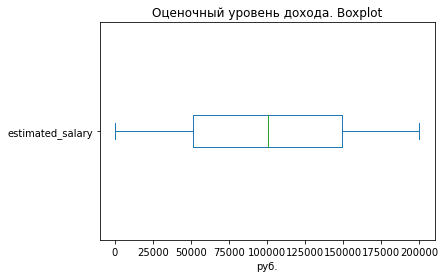

In [14]:
# boxplot

data['estimated_salary'].plot(kind='box', vert=False, figsize=(6, 4))

plt.title('Оценочный уровень дохода. Boxplot')
plt.xlabel('руб.');

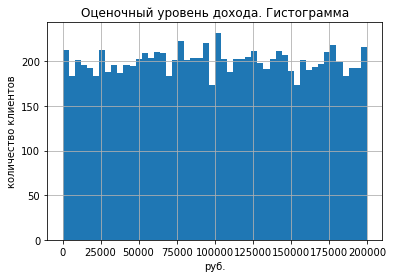

In [15]:
# гистограмма

data['estimated_salary'].hist(bins=50)

plt.title('Оценочный уровень дохода. Гистограмма')
plt.xlabel('руб.')
plt.ylabel('количество клиентов');

___
**Можем отметить:**
- равномерное распределение оценочночного дохода среди клиентов;
- отсутсвие выбросов;
- т.к. у нас нет информации о методике оценки уровня дохода и точности оценки, сделаем предположение, крайне малые значения могут быть результатом выплаты процентов по депозиту, начисления процентов на остаток по карте, кешбэк и т.д.. Поэтому оставим значения без изменений.
___

# Анализ данных

## Общее количество ушедших клиентов

In [29]:
# число ушедших и оставшихся клиентов

not_churn_churn = data['churn'].value_counts()

In [27]:
print(
    f'Общее число клиентов: {data.shape[0]}\n' 
    f'Число ушедших клиентов: {not_churn_churn[1]}\n'
    f'Процент ушедших клиентов: {((not_churn_churn[1]/data.shape[0])*100).round(1)}%'
     )

Общее число клиентов: 10000
Число ушедших клиентов: 2037
Процент ушедших клиентов: 20.4%


## Общее количество ушедших клиентов в разрезе городов присутсвия банка

In [35]:
# функция для формирования кросстаблицы

def cross_table(data, row, col):
    
    # сформируем кросстаблицу
    
    cross_table = pd.crosstab(data[row], data[col])
    
    # добавим столбец с общим числом клиентов
    
    cross_table['total'] = cross_table[1]+cross_table[0]
    
    # добавим столбец с процентом 
    
    cross_table['percent_'+col] = ((cross_table[1]/cross_table['total'])*100).round()
    
    return cross_table

In [36]:
chur_by_city = cross_table(data, 'city', 'churn')
chur_by_city

churn,0,1,total,percent_churn
city,,,,
Ростов Великий,1695,814,2509,32.0
Рыбинск,2064,413,2477,17.0
Ярославль,4204,810,5014,16.0


___
**Можем отметить:**
- наибольшее число клиентов в Ярославле;
- наименьшее число клиентов в Ростове Великом;
- наибольшее число ушедших клиентов в Ростове Великом;
- процент оттка в Ростове Великом в два раза больше чем в Рыбинске и Ярославле;
___

## Активность клиентов

In [37]:
# сформируем кросстаблицу

chur_by_loyalty = cross_table(data, 'loyalty', 'churn')
chur_by_loyalty

churn,0,1,total,percent_churn
loyalty,,,,
0,3547,1302,4849,27.0
1,4416,735,5151,14.0


___
**Можем отметить** процент ушедших клиентов среди неактивных почти в два раза выше
___

### По городам

In [38]:
for i in data['city'].unique():
    tmp_data = data.query('city == @i')
    tmp_cross_table = cross_table(tmp_data, 'loyalty', 'churn')
    print(f'{i}')
    print('-'*len(i)) 
    print(f'{tmp_cross_table}')
    print('-'*40)

Ярославль
---------
churn       0    1  total  percent_churn
loyalty                                 
0        1911  512   2423           21.0
1        2293  298   2591           12.0
----------------------------------------
Рыбинск
-------
churn       0    1  total  percent_churn
loyalty                                 
0         893  272   1165           23.0
1        1171  141   1312           11.0
----------------------------------------
Ростов Великий
--------------
churn      0    1  total  percent_churn
loyalty                                
0        743  518   1261           41.0
1        952  296   1248           24.0
----------------------------------------


___
**Можем отметить** количество ушедших клиентов в Ростове Великом выше по обеим категориям.
___

## Баллы кредитного скоринга

In [39]:
# диапазон значений кредитного скоринга

data['score'].min(), data['score'].max()

(350, 850)

In [40]:
# сформируем группы кредитного скоринга

score_gr = np.arange(350, 851, 50)

# Скорректируем начальное значение

score_gr[0] = 349

In [41]:
# сгруппируем значения кредитного скоринга

data['score_group'] = pd.cut(data['score'], score_gr)

In [42]:
# напишем функцию для формирования сводной таблицы

def churn_by_group(data, group):
    
    # сформируем сводную таблицу
    
    chur_by_group = cross_table(data, group, 'churn')
    
    # перенесем категории из индекса и заменим тип данных на текстовый
    
    chur_by_group = chur_by_group.reset_index()
    chur_by_group[group] = chur_by_group[group].astype(str)
    
    return chur_by_group

In [43]:
churn_by_score_group = churn_by_group(data, 'score_group')
churn_by_score_group

churn,score_group,0,1,total,percent_churn
0,"(349, 400]",0,19,19,100.0
1,"(400, 450]",128,42,170,25.0
2,"(450, 500]",363,91,454,20.0
3,"(500, 550]",762,216,978,22.0
4,"(550, 600]",1148,297,1445,21.0
5,"(600, 650]",1479,392,1871,21.0
6,"(650, 700]",1586,361,1947,19.0
7,"(700, 750]",1212,306,1518,20.0
8,"(750, 800]",767,186,953,20.0
9,"(800, 850]",518,127,645,20.0


In [44]:
# Видим небольшое количество клиентов в группах 350-400, 400-450. Объединим группы

In [45]:
score_gr = np.arange(400, 851, 50)

score_gr[0] = 349

data['score_group'] = pd.cut(data['score'], score_gr)

In [46]:
churn_by_score_group = churn_by_group(data, 'score_group')
churn_by_score_group

churn,score_group,0,1,total,percent_churn
0,"(349, 450]",128,61,189,32.0
1,"(450, 500]",363,91,454,20.0
2,"(500, 550]",762,216,978,22.0
3,"(550, 600]",1148,297,1445,21.0
4,"(600, 650]",1479,392,1871,21.0
5,"(650, 700]",1586,361,1947,19.0
6,"(700, 750]",1212,306,1518,20.0
7,"(750, 800]",767,186,953,20.0
8,"(800, 850]",518,127,645,20.0


In [47]:
# Напишем функцию для построения линейного графика количества ушедших и оставшихся клиентов

def churn_not_churn_plot(cross_table, group,
                        title = ' ',
                        x_title = ' '):
    
    plt.figure(figsize=(15, 6))

    plt.plot(cross_table[group], cross_table[0], label='остались', linewidth = '3')
    
    plt.plot(cross_table[group], cross_table[1], label='ушли', linewidth = '3')
    
    plt.title('Ушедшие/оставшиеся клиенты. Распределение по ' + title )
    plt.xlabel(x_title)
    plt.ylabel('количество клиентов')
    
    plt.grid()
    plt.legend();

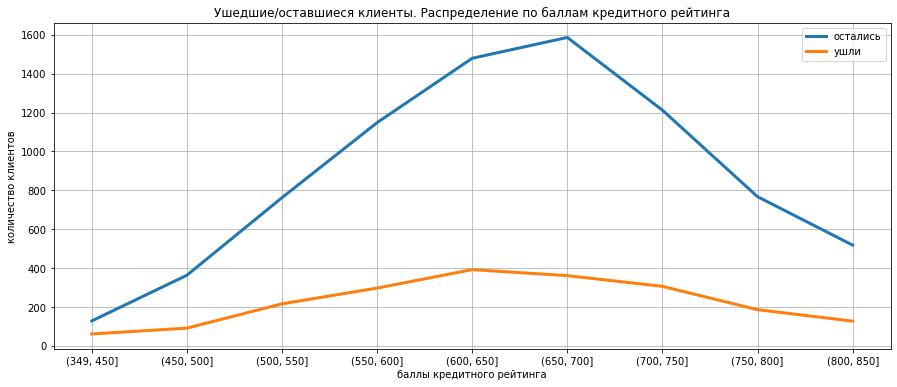

In [48]:
# Построим график количество ушедших и оставшихся клиентов в зависимости от баллов кредитного рейтинга

churn_not_churn_plot(churn_by_score_group, 'score_group',
                    "баллам кредитного рейтинга",
                    "баллы кредитного рейтинга")

In [49]:
# Напишем функцию для построения столбиковой диаграммы процента ушедших клиентов

def churn_percent_bar(cross_table, group, 
                     title = " ",
                     x_label = " "):
    
    plt.figure(figsize=(18, 6))

    plt.bar(cross_table[group], cross_table['percent_churn'],
             linewidth = '3', label='отток')

    plt.title('Процент оттока. Распределение по ' + title)
    plt.xlabel(x_label)
    plt.ylabel('%')

    # добавим линию среднего значения оттока
    
    plt.axhline(20.4, linestyle = '--', color = 'red', label='срдений отток')

    plt.grid()
    plt.legend();

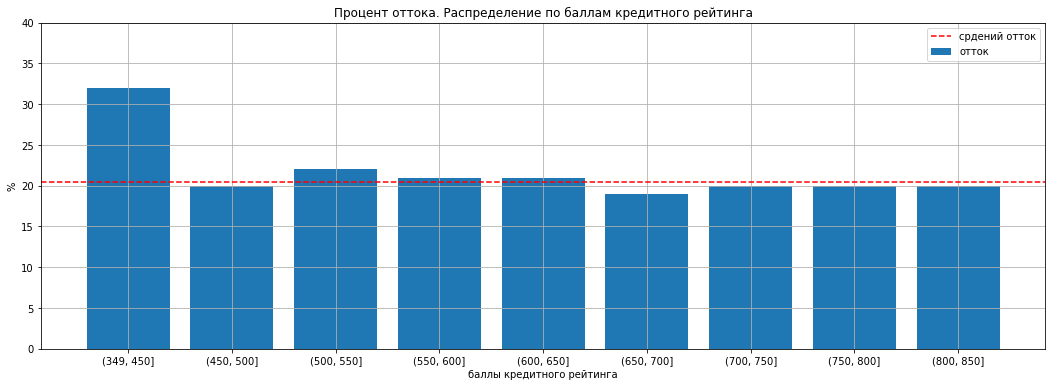

In [50]:
churn_percent_bar(churn_by_score_group, 'score_group',
                    "баллам кредитного рейтинга",
                    "баллы кредитного рейтинга")

plt.ylim(0, 40);

___
**Можно отметить:**
- уровень оттока находится в диапазоне 19-32%;
- 32% оттока имеют клиенты с рейтингом от 350 до 450. За исключением данной категории % оттока от 19 до 22%.
___

### По городам

In [51]:
# напишем функцию для формирования сводных таблици по городам присутсвия банка

def churn_by_group_city(data, group):
    
    # Ярославль
    churn_by_group_yaroslavl = churn_by_group(data.query('city == "Ярославль"'), group)
    
    # Рыбинск
    churn_by_groupribinsk = churn_by_group(data.query('city == "Рыбинск"'), group)
    
    # Ростов Великий
    churn_by_group_rostov = churn_by_group(data.query('city == "Ростов Великий"'), group)
    
    return churn_by_group_yaroslavl, churn_by_groupribinsk, churn_by_group_rostov

In [52]:
# сформируем сводные таблицы по городам

churn_by_score_group_yaroslavl, churn_by_score_group_ribinsk, churn_by_score_group_rostov = (
    churn_by_group_city(data, 'score_group')
) 

In [53]:
# Напишем фунцию для объединения совдных таблиц

def group_merge(churn_by_group_yaroslavl, churn_by_groupribinsk, churn_by_group_rostov, group, total=False):
    
    """
    последовательность городво: yaroslavl, ribinsk, rostov
    """
    # Не добавляем столбец total
    
    if total==False:
    
        display(
        pd.merge(
            
            # Объединяем Ярославль и Рыбинск
            
        pd.merge(churn_by_group_yaroslavl[[group,'percent_churn']],
             churn_by_groupribinsk[[group,'percent_churn']],
             on = group, how = 'outer', suffixes=('_yar','_rib')),
            
            # Объеядиняем с Ростовом Великим
            
             churn_by_group_rostov[[group,'percent_churn']],
             on = group, how = 'outer'
            ).rename(columns={'percent_churn':'percent_churn_rost'})
        )
        
        # Добавляем столбец total
        
    else:
        display(
        pd.merge(
            
            # Объединяем Ярославль и Рыбинск
            
        pd.merge(churn_by_group_yaroslavl[[group,'percent_churn', 'total']],
             churn_by_groupribinsk[[group,'percent_churn', 'total']],
             on = group, how = 'outer', suffixes=('_yar','_rib')),
            
            # Объеядиняем с Ростовом Великим
            
             churn_by_group_rostov[[group,'percent_churn', 'total']],
             on = group, how = 'outer'
            ).rename(columns={'percent_churn':'percent_churn_rost',
                             'total': 'total_rost'})
        )

In [54]:
group_merge(churn_by_score_group_yaroslavl,
            churn_by_score_group_ribinsk,
            churn_by_score_group_rostov,
            'score_group')

churn,score_group,percent_churn_yar,percent_churn_rib,percent_churn_rost
0,"(349, 450]",23.0,36.0,50.0
1,"(450, 500]",18.0,11.0,30.0
2,"(500, 550]",18.0,17.0,36.0
3,"(550, 600]",16.0,17.0,34.0
4,"(600, 650]",17.0,17.0,32.0
5,"(650, 700]",16.0,15.0,29.0
6,"(700, 750]",15.0,18.0,33.0
7,"(750, 800]",14.0,14.0,34.0
8,"(800, 850]",15.0,17.0,30.0


In [55]:
# напишем функцию для построения графика % оттока по городам

def churn_percent_by_city(churn_by_group_yaroslavl, 
                         churn_by_groupribinsk,
                         churn_by_group_rostov,
                         group,
                         title,
                         x_label):
    
    plt.figure(figsize=(15, 6))

    plt.plot(churn_by_group_yaroslavl[group], churn_by_group_yaroslavl['percent_churn']
             ,label='Ярославль', linewidth = '3')

    plt.plot(churn_by_groupribinsk[group], churn_by_groupribinsk['percent_churn']
             ,label='Рыбинск', linewidth = '3')

    plt.plot(churn_by_group_rostov[group], churn_by_group_rostov['percent_churn']
             ,label='Ростов Великий', linewidth = '3', color = 'red')

    plt.title('Процент оттока. Распределение по ' + title)
    plt.xlabel(x_label)
    plt.ylabel('%')

    plt.grid()
    plt.legend();

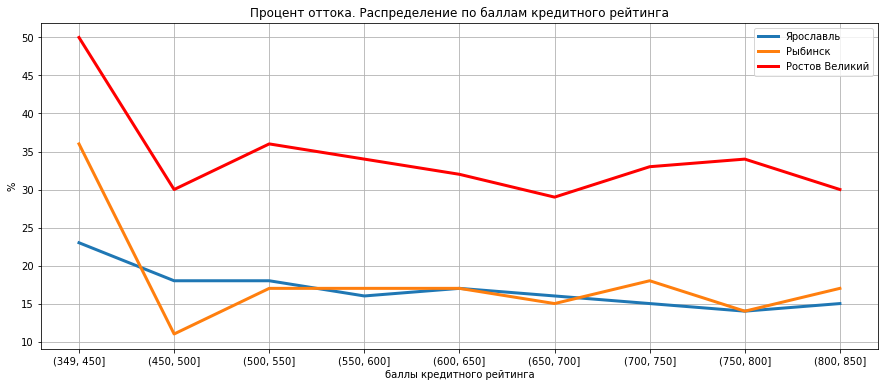

In [56]:
# Построим линейный график % оттока по городам

churn_percent_by_city(churn_by_score_group_yaroslavl,
            churn_by_score_group_ribinsk,
            churn_by_score_group_rostov,
            'score_group',
                         'баллам кредитного рейтинга',
                         'баллы кредитного рейтинга')

___
**Можно отметить** в Ростове Великом превышение показателя оттока клиентов по всем группам кредитного рейтинга.
___

## Количество продуктов

In [57]:
# диапазон значений количества продуктов

data['products'].min(), data['products'].max()

(1, 4)

In [58]:
churn_by_products = cross_table(data, 'products', 'churn')
churn_by_products

churn,0,1,total,percent_churn
products,,,,
1,3675,1409,5084,28.0
2,4242,348,4590,8.0
3,46,220,266,83.0
4,0,60,60,100.0


**Можно отметить:**
- отток клиентов имеющих два продукта ниже чем имеющих один, но отток клиентов имеющих три и четыре продука выше чем имеющих один и два;
- разброс значений относительно среднего % оттока от -12.4% до 79.6%(объединили 3 и 4 продукт)
- количество клиентов имеющих три и четыре продукта составляет 3% от общего числа клиентов.

**Можно предположить:**
- один - минимальное количество продуктов, клиенты еще могли не получить положительный или отрицательный опыт использования продуктов банка;
- второй продукт оформляют клиенты получившие положительный опыт использования первого продукта и более лояльные к банку;
- третий и четвертый - рузультат "успешной" продажи. 

Для более обоснованных предположений следует уточнить сценарии получения 2, 3 и 4 продуктов.

### По городам

In [59]:
# сформируем сводные таблицы по городам

churn_by_products_yaroslavl, churn_by_products_ribinsk, churn_by_products_rostov = (
    churn_by_group_city(data, 'products')
)

In [60]:
# Объединим % оттока по городам

group_merge(churn_by_products_yaroslavl,
            churn_by_products_ribinsk,
            churn_by_products_rostov,
            'products')

churn,products,percent_churn_yar,percent_churn_rib,percent_churn_rost
0,1,22.0,22.0,43.0
1,2,6.0,7.0,12.0
2,3,79.0,79.0,90.0
3,4,100.0,100.0,100.0


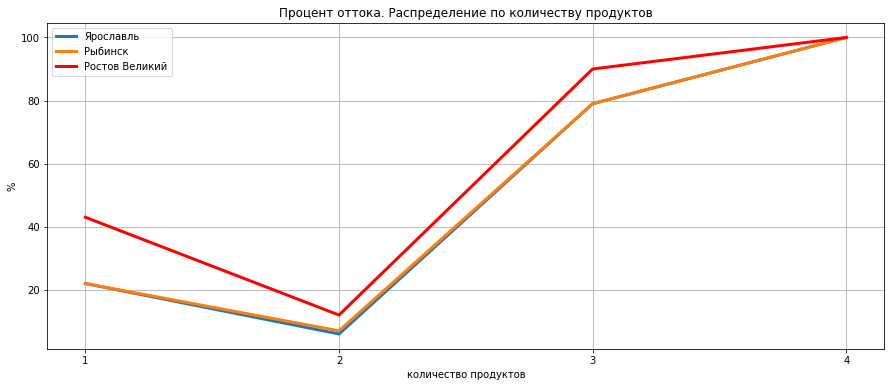

In [61]:
# Построим график % оттока по городам

churn_percent_by_city(churn_by_products_yaroslavl,
            churn_by_products_ribinsk,
            churn_by_products_rostov,
            'products',
                         'количеству продуктов',
                         'количество продуктов')

___
**Можно отметить** различия оттока клиентов имеющих 3 и 4 продукта менее выражены мужду Ростовом Великим и Ярославлем, Рыбинском
___

## Количество объектов

In [62]:
# диапазон значений количества объектов

data['objects'].min(), data['objects'].max()

(0, 10)

In [63]:
churn_by_objects = cross_table(data, 'objects', 'churn')
churn_by_objects = churn_by_objects.reset_index()
churn_by_objects

churn,objects,0,1,total,percent_churn
0,0,318,95,413,23.0
1,1,803,232,1035,22.0
2,2,847,201,1048,19.0
3,3,796,213,1009,21.0
4,4,786,203,989,21.0
5,5,803,209,1012,21.0
6,6,771,196,967,20.0
7,7,851,177,1028,17.0
8,8,828,197,1025,19.0
9,9,771,213,984,22.0


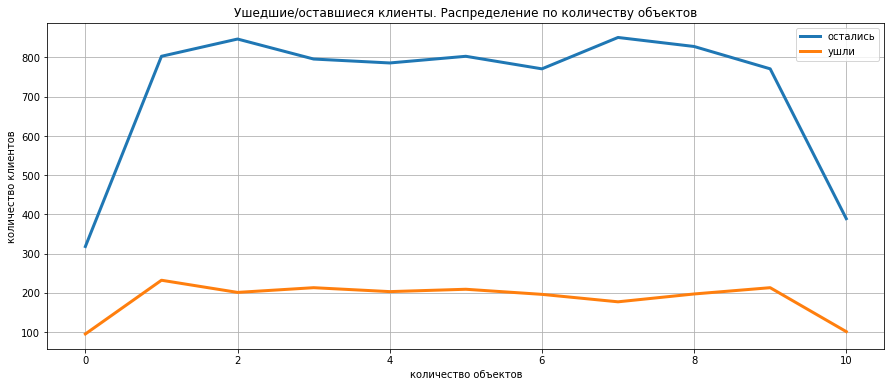

In [64]:
# Построим график количество ушедших и оставшихся клиентов в зависимости от количества объектов

churn_not_churn_plot(churn_by_objects, 'objects',
                    "количеству объектов",
                    "количество объектов")

(0.0, 40.0)

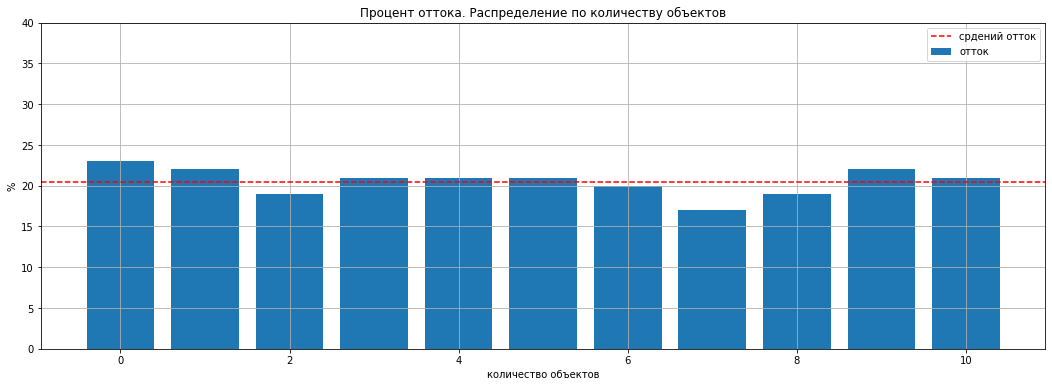

In [65]:
churn_percent_bar(churn_by_objects, 'objects',
                    "количеству объектов",
                    "количество объектов")

plt.ylim(0, 40)

**Можно отметить:**
- диапазон значений оттока от 17 до 23 %;
- отсутсвие ярко выраженной корреляции;
- можно сделать вывод об отсутсвии связи между количеством объектов и уровнем оттока клиентов.

### По городам

In [66]:
# сформируем сводные таблицы по городам

churn_by_objects_yaroslavl, churn_by_objects_ribinsk, churn_by_objects_rostov = (
    churn_by_group_city(data, 'objects')
) 

In [67]:
group_merge(churn_by_objects_yaroslavl, churn_by_objects_ribinsk, churn_by_objects_rostov,
            'objects', total=True)

churn,objects,percent_churn_yar,total_yar,percent_churn_rib,total_rib,percent_churn_rost,total_rost
0,0,17.0,205,23.0,103,34.0,105
1,1,16.0,529,18.0,242,40.0,264
2,2,17.0,525,19.0,248,23.0,275
3,3,17.0,491,18.0,257,32.0,261
4,4,17.0,512,17.0,245,33.0,232
5,5,16.0,485,16.0,268,35.0,259
6,6,15.0,503,18.0,237,33.0,227
7,7,14.0,552,16.0,251,27.0,225
8,8,15.0,465,14.0,296,33.0,264
9,9,17.0,504,15.0,211,35.0,269


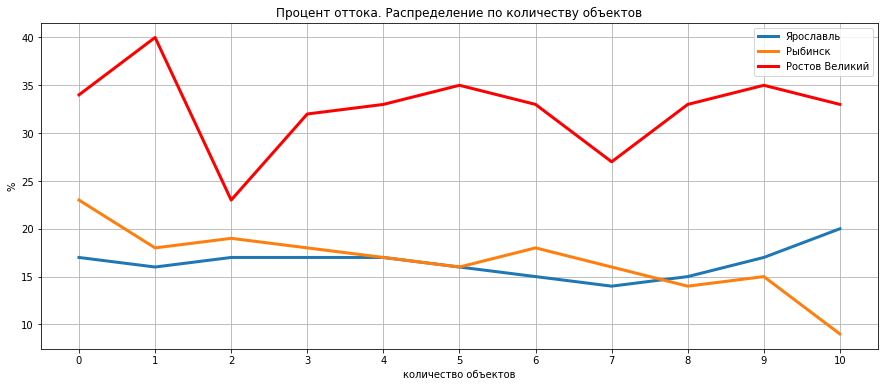

In [68]:
# Построим линейный график % оттока по городам

churn_percent_by_city(churn_by_objects_yaroslavl, churn_by_objects_ribinsk, churn_by_objects_rostov,
            'objects',
                         "количеству объектов",
                    "количество объектов")

**Можно отметить:**
- Превышение оттока в Ростове Великом по всем категориям;

## Наличие кредитной карты

In [69]:
# сформируем кросстаблицу

churn_by_credit_card = cross_table(data, 'credit_card', 'churn')
churn_by_credit_card

churn,0,1,total,percent_churn
credit_card,,,,
0,2332,613,2945,21.0
1,5631,1424,7055,20.0


___
**Можно отметить** схожие значения оттока клиентов обладающих кредитной картой и не обладающих
___

### По городам

In [70]:
for i in data['city'].unique():
    tmp_data = data.query('city == @i')
    tmp_cross_table = cross_table(tmp_data, 'credit_card', 'churn')
    print(f'{i}')
    print('-'*len(i)) 
    print(f'{tmp_cross_table}')
    print('-'*40)

Ярославль
---------
churn           0    1  total  percent_churn
credit_card                                 
0            1230  241   1471           16.0
1            2974  569   3543           16.0
----------------------------------------
Рыбинск
-------
churn           0    1  total  percent_churn
credit_card                                 
0             621  135    756           18.0
1            1443  278   1721           16.0
----------------------------------------
Ростов Великий
--------------
churn           0    1  total  percent_churn
credit_card                                 
0             481  237    718           33.0
1            1214  577   1791           32.0
----------------------------------------


___
**Можно отметить** во всех городах наблюдается схожее соотношение оттока клиентов обладающих кредитной картой и не обладающих
___

## Баланс

In [71]:
# минимальный и максимальный баланс

balance_min, balance_max = data.query('balance !=0')['balance'].min(), data['balance'].max()
balance_min, balance_max

(3768.69, 250898.09)

In [72]:
# установим значения для групп

balance_group = [-0.1, 0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, 10000000]

In [73]:
# добавим группы

data['balance_group'] = pd.cut(data['balance'], balance_group)

In [74]:
churn_by_balance_group = churn_by_group(data, 'balance_group')
churn_by_balance_group

churn,balance_group,0,1,total,percent_churn
0,"(-0.1, 0.0]",3117,500,3617,14.0
1,"(0.0, 25000.0]",2,4,6,67.0
2,"(25000.0, 50000.0]",47,22,69,32.0
3,"(50000.0, 75000.0]",274,75,349,21.0
4,"(75000.0, 100000.0]",935,225,1160,19.0
5,"(100000.0, 125000.0]",1510,558,2068,27.0
6,"(125000.0, 150000.0]",1333,429,1762,24.0
7,"(150000.0, 175000.0]",582,156,738,21.0
8,"(175000.0, 200000.0]",148,49,197,25.0
9,"(200000.0, 10000000.0]",15,19,34,56.0


In [75]:
# объединим группы 0 - 25 000 и 25 000 - 50 000, 175 000 - 200 000 и >200 000 
# ввиду небольшого количества клиентов в группах

balance_group = [-0.1, 0, 50000, 75000, 100000, 125000, 150000, 175000, 10000000]

data['balance_group'] = pd.cut(data['balance'], balance_group)

churn_by_balance_group = churn_by_group(data, 'balance_group')
churn_by_balance_group

churn,balance_group,0,1,total,percent_churn
0,"(-0.1, 0.0]",3117,500,3617,14.0
1,"(0.0, 50000.0]",49,26,75,35.0
2,"(50000.0, 75000.0]",274,75,349,21.0
3,"(75000.0, 100000.0]",935,225,1160,19.0
4,"(100000.0, 125000.0]",1510,558,2068,27.0
5,"(125000.0, 150000.0]",1333,429,1762,24.0
6,"(150000.0, 175000.0]",582,156,738,21.0
7,"(175000.0, 10000000.0]",163,68,231,29.0


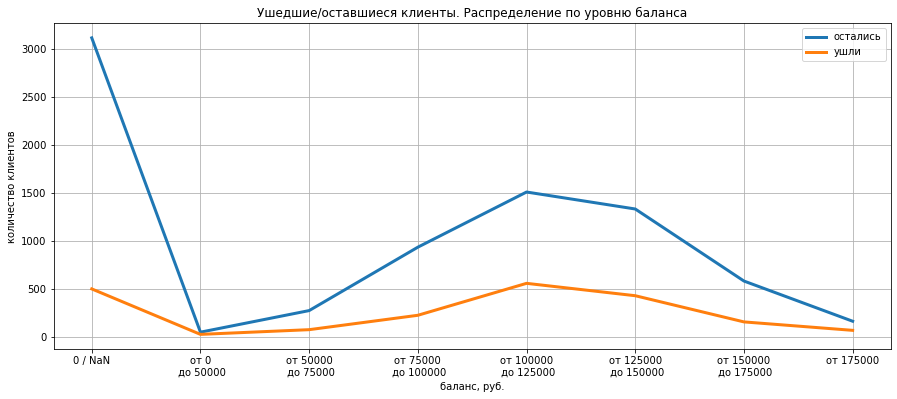

In [76]:
churn_not_churn_plot(churn_by_balance_group, 'balance_group',
                    "уровню баланса",
                    "баланс, руб.")

# скорректируем подписи для оси X

x_label = []

for i, ii in enumerate(balance_group):
    if i == 0:
        x_label.append(f'0 / NaN')
        
    elif ii == balance_group[-2]:
        x_label.append(f'от {balance_group[i]}')
        
    elif ii == balance_group[-1]:
        break
        
    else:
        x_label.append(f'от {balance_group[i]}\n до {balance_group[i+1]}')

plt.xticks(churn_by_balance_group['balance_group'], x_label);

In [77]:
# добавим столбец с процентом клиентов в каждой группе от общего числа

churn_by_balance_group['total_percent_client'] = churn_by_balance_group.eval('(total/@data.shape[0])*100')
churn_by_balance_group

churn,balance_group,0,1,total,percent_churn,total_percent_client
0,"(-0.1, 0.0]",3117,500,3617,14.0,36.17
1,"(0.0, 50000.0]",49,26,75,35.0,0.75
2,"(50000.0, 75000.0]",274,75,349,21.0,3.49
3,"(75000.0, 100000.0]",935,225,1160,19.0,11.60
4,"(100000.0, 125000.0]",1510,558,2068,27.0,20.68
5,"(125000.0, 150000.0]",1333,429,1762,24.0,17.62
6,"(150000.0, 175000.0]",582,156,738,21.0,7.38
7,"(175000.0, 10000000.0]",163,68,231,29.0,2.31


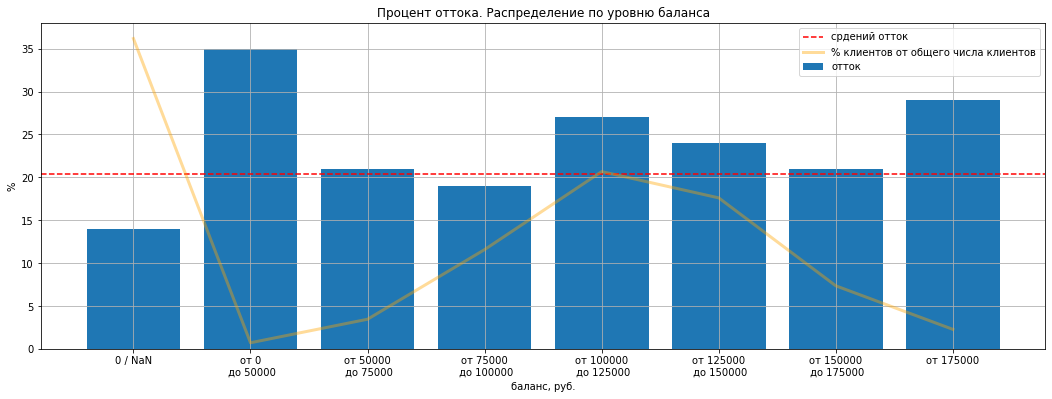

In [78]:
churn_percent_bar(churn_by_balance_group, 'balance_group',
                     "уровню баланса",
                    "баланс, руб.")

# добавим процент клиентов от общего числа в каждой группе 

plt.plot(churn_by_balance_group['balance_group'], churn_by_balance_group['total_percent_client'],
         linewidth = '3', label='% клиентов от общего числа клиентов', color = 'orange', alpha=0.4)

# скорректируем подписи для оси X

plt.xticks(churn_by_balance_group['balance_group'], x_label)

plt.legend();

**Можно отметить:**
- отсутсвие ярко выраженной корреляции между балансом и % оттока клиентов;
- следует обратить внимание, что клиенты с 0-м балансом имеют ниже показатель оттока (14%). Следует помнить, что баланс - 0, результат восстановаления пропущенных значений. Следует выяснить причины пропусков.
- Отток клиентов с крайними значениями баланса имеет повышенные значения оттока, 35 и 29. Следует ометить небольшое количество клиентов в данных группах: 0.75% и 2.3%. Можно выдвинуть гипотезу, что продукты банка и стандарты работы с клиентами не подходят для работы с клиентами как с небольшим так большим балансом.
- Следует отметить для самой многочисленной группы 100 000 - 125 000 % оттока составляет 27%.
- Следует выяснить методологию определения баланса, в частности по ушедшим клиентам определяется на момент ухода или иным способом.

### По городам

In [79]:
# сформируем сводные таблицы по городам

churn_by_balance_group_yaroslavl, churn_by_balance_group_ribinsk, churn_by_balance_group_rostov = (
    churn_by_group_city(data, 'balance_group')
) 

In [80]:
# объединим % оттока по городам

group_merge(churn_by_balance_group_yaroslavl,
            churn_by_balance_group_ribinsk,
            churn_by_balance_group_rostov,
            'balance_group', 
           total=True)

churn,balance_group,percent_churn_yar,total_yar,percent_churn_rib,total_rib,percent_churn_rost,total_rost
0,"(-0.1, 0.0]",14.0,2418,14.0,1199,NaN,NaN
1,"(0.0, 50000.0]",49.0,41,40.0,15,0.0,19.0
2,"(50000.0, 75000.0]",23.0,167,39.0,75,7.0,107.0
3,"(75000.0, 100000.0]",15.0,480,20.0,263,24.0,417.0
4,"(100000.0, 125000.0]",15.0,766,14.0,382,42.0,920.0
5,"(125000.0, 150000.0]",17.0,710,16.0,320,35.0,732.0
6,"(150000.0, 175000.0]",20.0,317,20.0,164,23.0,257.0
7,"(175000.0, 10000000.0]",36.0,115,44.0,59,2.0,57.0


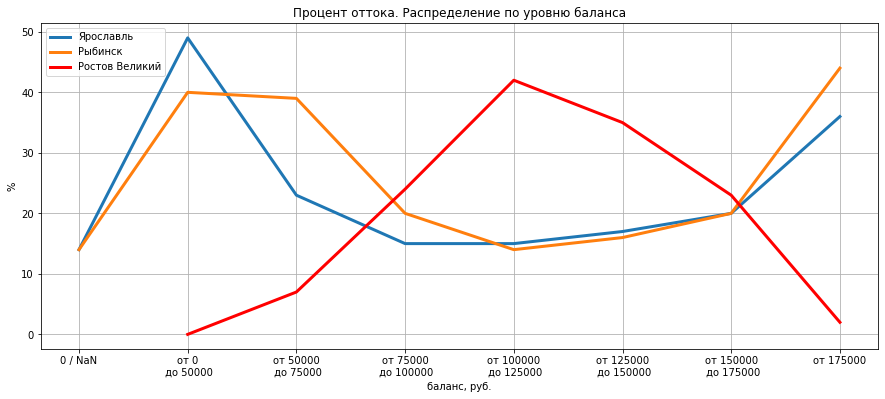

In [81]:
churn_percent_by_city(churn_by_balance_group_yaroslavl,
            churn_by_balance_group_ribinsk,
            churn_by_balance_group_rostov,
            'balance_group',
                         'уровню баланса',
                         'баланс, руб.')

# скорректируем подписи для оси X

plt.xticks(churn_by_balance_group['balance_group'], x_label);

**Можно отметить:**
- характер распределения в Ростове Великом (минимальный отток на крайних значениях баланса, увеличивается к среднему значению) прямо противоположен характеру распределения в Ярославле и Рыбинске (показатели оттока выше на краях значений баланса, уменьшаются к центральному значению)
- Можно выдвинуть гипотезу: в Ростове Великом попытались сократить показатели оттка для клиентов с крайними значениями баланса, добились в этом успеха, на при этом ухудшили показатель оттока для осталных клиентов.
- Пиковое значение оттока в Ростове Великом - 42% приходится на самую многочисленную группу 100 000 - 125 000р., этим и обясняется повышенные значения оттока на общем графике.
- Следует обратить внимание в Ростове Великом отсутсвуют клиенты с отсутсвующими значениями баланса.

## Оценка дохода

In [82]:
# минимальная, максимальная оценочная з/п

salary_min, salary_max = data['estimated_salary'].min(), data['estimated_salary'].max()
salary_min, salary_max

(11.58, 199992.48)

In [83]:
#  сформируем значения групп

salary_group = np.arange(0, 200001, 25000)

In [84]:
# сформируем группы

data['salary_group'] = pd.cut(data['estimated_salary'], salary_group)

In [85]:
churn_by_salary_group = churn_by_group(data, 'salary_group')
churn_by_salary_group

churn,salary_group,0,1,total,percent_churn
0,"(0, 25000]",975,242,1217,20.0
1,"(25000, 50000]",989,247,1236,20.0
2,"(50000, 75000]",1003,266,1269,21.0
3,"(75000, 100000]",1030,238,1268,19.0
4,"(100000, 125000]",1020,256,1276,20.0
5,"(125000, 150000]",1018,261,1279,20.0
6,"(150000, 175000]",941,254,1195,21.0
7,"(175000, 200000]",987,273,1260,22.0


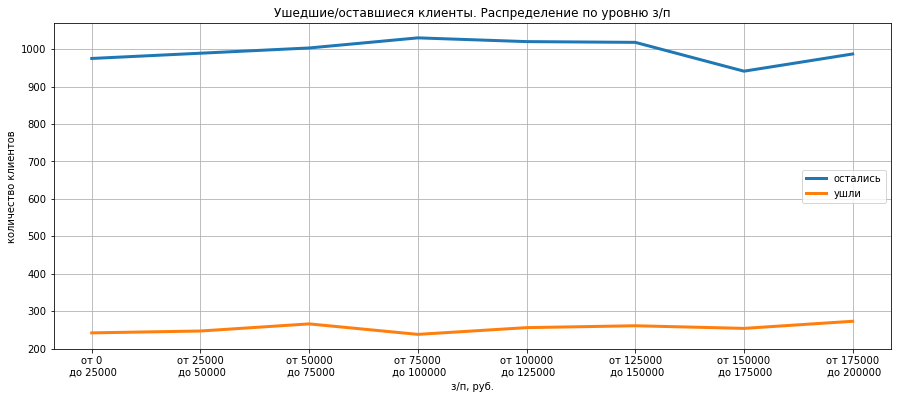

In [86]:
# построим график количество ушедших и оставшихся клиентов

churn_not_churn_plot(churn_by_salary_group, 'salary_group',
                    'уровню з/п',
                    'з/п, руб.')

x_label = []

for i, ii in enumerate(salary_group):
    
    if ii == salary_group[-1]:
        break
        
    else:
        x_label.append(f'от {salary_group[i]}\n до {salary_group[i+1]}')

plt.xticks(churn_by_salary_group['salary_group'], x_label);

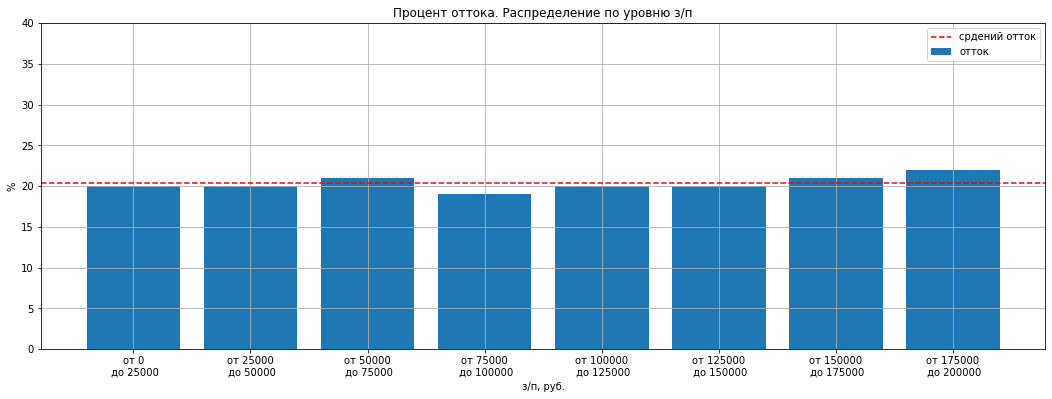

In [87]:
# построим график % оттока

churn_percent_bar(churn_by_salary_group, 'salary_group',
                    'уровню з/п',
                    'з/п, руб.')

plt.ylim(0, 40)

plt.xticks(churn_by_salary_group['salary_group'], x_label);

**Можно отметить:**
- диапазон значений оттока от 19 до 22 % без какой-либо ярко выраженной динамики. Что говорит об отсутсвия связи между оценочным уровнем з/п и оттокам клиентов.

### По городам

In [88]:
# сформируем сводные таблицы по городам

churn_by_salary_group_yaroslavl, churn_by_salary_group_ribinsk, churn_by_salary_group_rostov = (
churn_by_group_city(data, 'salary_group')
)

In [89]:
# объединим % оттока по городам

group_merge(churn_by_salary_group_yaroslavl,
            churn_by_salary_group_ribinsk,
            churn_by_salary_group_rostov,
            'salary_group')

churn,salary_group,percent_churn_yar,percent_churn_rib,percent_churn_rost
0,"(0, 25000]",15.0,15.0,36.0
1,"(25000, 50000]",14.0,15.0,36.0
2,"(50000, 75000]",17.0,16.0,33.0
3,"(75000, 100000]",15.0,16.0,30.0
4,"(100000, 125000]",16.0,16.0,33.0
5,"(125000, 150000]",17.0,18.0,30.0
6,"(150000, 175000]",17.0,23.0,28.0
7,"(175000, 200000]",19.0,15.0,33.0


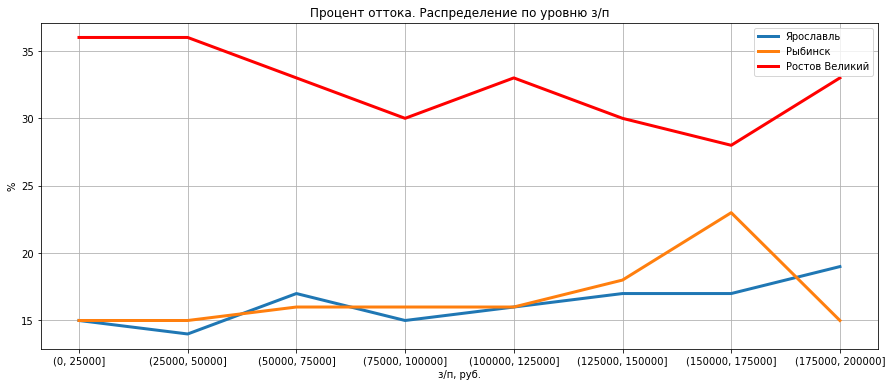

In [90]:
churn_percent_by_city(churn_by_salary_group_yaroslavl,
            churn_by_salary_group_ribinsk,
            churn_by_salary_group_rostov,
            'salary_group',
                         'уровню з/п',
                         'з/п, руб.')

___
**Можно отметить** в Ростове Великом превышение показателя оттока клиентов по всем группам з/п.
___

## Возраст

In [91]:
# диапазон значений возраста

data['age'].min(), data['age'].max()

(18, 92)

In [92]:
# сформируем значения для возрастных групп

age_group = [17, 25, 35, 45, 55, 65, 100]

In [93]:
# сформируем группы

data['age_group'] = pd.cut(data['age'], age_group)

In [94]:
churn_by_age = churn_by_group(data, 'age_group')
churn_by_age

churn,age_group,0,1,total,percent_churn
0,"(17, 25]",565,46,611,8.0
1,"(25, 35]",3241,301,3542,8.0
2,"(35, 45]",3003,733,3736,20.0
3,"(45, 55]",648,663,1311,51.0
4,"(55, 65]",277,259,536,48.0
5,"(65, 100]",229,35,264,13.0


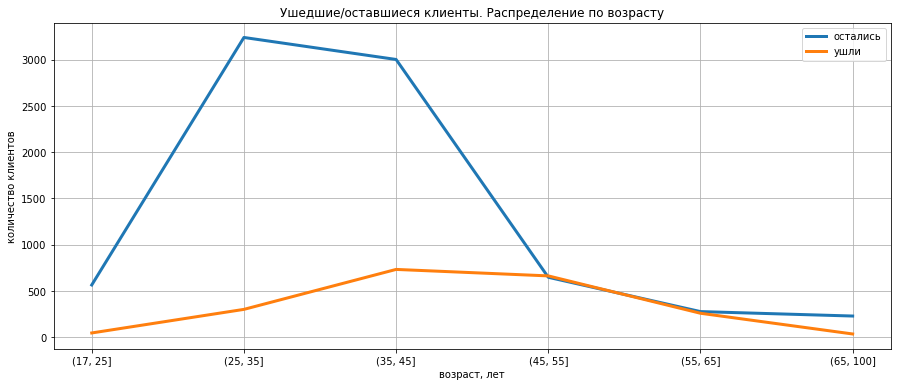

In [95]:
# построим график количество ушедших и оставшихся клиентов

churn_not_churn_plot(churn_by_age, 'age_group',
                    'возрасту',
                    'возраст, лет')

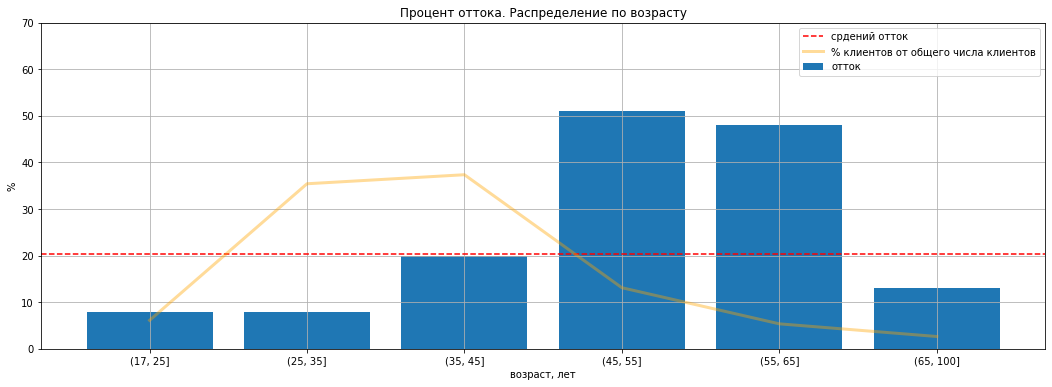

In [96]:
# построим график % оттока

churn_percent_bar(churn_by_age, 'age_group',
                    'возрасту',
                    'возраст, лет')

# добавим процент клиентов от общего числа в каждой группе

churn_by_age['total_percent'] = churn_by_age.eval('(total/@data.shape[0])*100')

plt.plot(churn_by_age['age_group'], churn_by_age['total_percent'],
         linewidth = '3', label='% клиентов от общего числа клиентов', color = 'orange', alpha=0.4)

plt.legend()

plt.ylim(0, 70);

**Можно отметить:**
- диапазон значений оттока от 8 до 51 %
- отток ниже среднего - 8% для возрастных групп от 17 до 25 и от 25 до 35 лет, 13 для возрастной группы от 65 лет
- отток выше среднего 51 и 48 для возрастных групп от 45 до 55 и от 55 до 65 лет.
- можно сделать предположения, подобные значения оттока связаны с параметрами(условиями) продуктов;
- для формирования рекомендаций необходимо более обоснованное предположение о причинах оттока, в частности данные по параметрам продуктов, стратегия банка, конкурентный анализ.

### По городам

In [97]:
# сформируем сводные таблицы по городам

churn_by_age_yaroslavl, churn_by_age_ribinsk, chun_by_age_rostov = churn_by_group_city(data, 'age_group')

In [98]:
# объединим % оттока по городам

group_merge(churn_by_age_yaroslavl,
            churn_by_age_ribinsk,
            chun_by_age_rostov,
            'age_group')

churn,age_group,percent_churn_yar,percent_churn_rib,percent_churn_rost
0,"(17, 25]",5.0,9.0,11.0
1,"(25, 35]",6.0,9.0,15.0
2,"(35, 45]",16.0,15.0,31.0
3,"(45, 55]",44.0,41.0,67.0
4,"(55, 65]",45.0,37.0,65.0
5,"(65, 100]",9.0,10.0,25.0


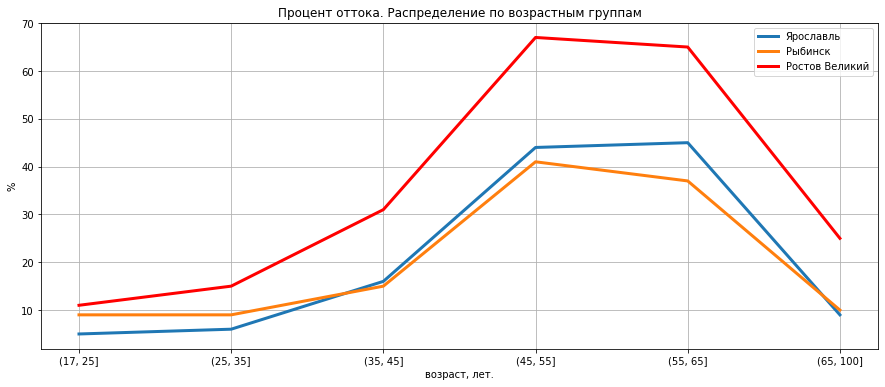

In [99]:
churn_percent_by_city(churn_by_age_yaroslavl,
            churn_by_age_ribinsk,
            chun_by_age_rostov,
            'age_group',
                         'возрастным группам',
                         'возраст, лет.')

___
**Можно отметить** в Ростове Великом превышение показателя оттока клиентов по всем возрастным группам.
___

## Пол

In [100]:
# сформируем кросстаблицу

chur_by_gender = cross_table(data, 'gender', 'churn')
chur_by_gender

churn,0,1,total,percent_churn
gender,,,,
Ж,3404,1139,4543,25.0
М,4559,898,5457,16.0


In [101]:
data.groupby('gender')['score'].mean()

gender
Ж    650.831389
М    650.276892
Name: score, dtype: float64

### По городам

In [103]:
for i in data['city'].unique():
    tmp_data = data.query('city == @i')
    tmp_cross_table = cross_table(tmp_data, 'gender', 'churn')
    print(f'{i}')
    print('-'*len(i)) 
    print(f'{tmp_cross_table}')
    print('-'*40)

Ярославль
---------
churn      0    1  total  percent_churn
gender                                 
Ж       1801  460   2261           20.0
М       2403  350   2753           13.0
----------------------------------------
Рыбинск
-------
churn      0    1  total  percent_churn
gender                                 
Ж        858  231   1089           21.0
М       1206  182   1388           13.0
----------------------------------------
Ростов Великий
--------------
churn     0    1  total  percent_churn
gender                                
Ж       745  448   1193           38.0
М       950  366   1316           28.0
----------------------------------------


**Можно отметить** в Ростове Великом превышение показателя оттока клиентов как среди мужчин, так и женщин.

# Проверка статистических гипотез

 ## Различие дохода между теми клиентами, которые ушли и теми, которые остались

Воспользуемся ранее сформированными группами по оценочному уровню з/п. Будем исходить из того, что если в какой-либо группе больше уходило или оставалось клиентов, то это приведет к изменению пропорции. Сравним пропорцию в каждой группе с пропорцией по всей выборке.

Для проверки статистической значимости будем использовать Z-тест

$Z \approx \frac{(P_1 - P_2) - (\pi_1 - \pi_2)}{\sqrt{ P*(1-P)*( \frac{1}{n_1} + \frac{1}{n_2}) }} $ 

$n_1$ и  $n_2$ - размеры двух сравниваемых выборок; <br/>
$P_1$ и $P_2$ - пропорции, наблюдаемые в выборках; <br/>
$P$ - пропорция в выборке, скомбинированной из двух наблюдаемых; <br/>
$\pi_1 - \pi_2$ - настоящие пропорции в сравниваемых генеральных совокупностях.

In [104]:
# Напишем функцию

def proportion_test(s1, s2, t1, t2, alpha=.05):
    
    # гурппа successes
    successes = np.array([s1, s2])
    
    # гурппа trials/observations
    trials = np.array([t1, t2])
    
    # пропорция 'успехов' в группе
    p1 = successes[0]/trials[0]

    p2 = successes[1]/trials[1]
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1])/ (trials[0] + trials[1])
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
    
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)
    
    #установим уровень статистической значимости:

    alpha = alpha 

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу. Различия есть.')
    
    else:
        print('Не отвергаем нулевую гипотезу, т.е. разницы нет')

Сформулируем гипотезы:

- $H_0$: нет различий в пропорции между оттоком клиентов в группе клиентов с определенным доходом и пропорции оттока клиентов по всей совокупности;
- $H_1$: различия есть;
- $\alpha$ = 0.05

Используем поправку Бонферрони на множественные сравнения.

bonferroni_alpha = $\alpha$ / 8

In [105]:
bonferroni_alpha = .05/8

print(f'входные параметры контрольная группа: {not_churn_churn[1]}, {data.shape[0]}')
print(f'пропорция контрольная группа: {"{0:.2f}".format((not_churn_churn[1]/data.shape[0])*100)}')
print('-'*50)

for index, row in churn_by_salary_group.iterrows():
    print(f'оценочный уровень дохода: {row["salary_group"]}')
    print(f'входные параметры: тестовая группа: {row[1]}, {row["total"]}')
    print(f'пропорция: {"{0:.2f}".format((row[1]/row["total"])*100)}\n')
    proportion_test(row[1], not_churn_churn[1],
                    row['total'], data.shape[0],
                    alpha=bonferroni_alpha)
    print('-'*50)

входные параметры контрольная группа: 2037, 10000
пропорция контрольная группа: 20.37
--------------------------------------------------
оценочный уровень дохода: (0, 25000]
входные параметры: тестовая группа: 242, 1217
пропорция: 19.88

p-значение:  0.6913164599464143
Не отвергаем нулевую гипотезу, т.е. разницы нет
--------------------------------------------------
оценочный уровень дохода: (25000, 50000]
входные параметры: тестовая группа: 247, 1236
пропорция: 19.98

p-значение:  0.7502787650020732
Не отвергаем нулевую гипотезу, т.е. разницы нет
--------------------------------------------------
оценочный уровень дохода: (50000, 75000]
входные параметры: тестовая группа: 266, 1269
пропорция: 20.96

p-значение:  0.622612195482581
Не отвергаем нулевую гипотезу, т.е. разницы нет
--------------------------------------------------
оценочный уровень дохода: (75000, 100000]
входные параметры: тестовая группа: 238, 1268
пропорция: 18.77

p-значение:  0.1811164489354704
Не отвергаем нулевую г

**Вывод:** различия в уровне з/п между теми клиентами, которые ушли и теми, которые остались - нет.

## Различие оттока между отделениями в разных городах

Проверим является ли % оттока клиентов между отделениями статистически значимым. Для проверки статистической значимости будем использовать Z-тест. Используем поправку Бонферрони на множественные сравнения.

bonferroni_alpha = $\alpha$ / 3

In [106]:
bonferroni_alpha = .05/3

Сформулируем гипотезы:

- $H_0$: нет различий в оттоке клиентов между отделениями в Ярославле и Рыбинске;
- $H_1$: различия есть;

In [107]:
proportion_test(413, 810, 2477, 5014, alpha=bonferroni_alpha)

p-значение:  0.5677610235238439
Не отвергаем нулевую гипотезу, т.е. разницы нет


Сформулируем гипотезы:

- $H_0$: нет различий в оттоке клиентов между отделениями в Ярославле и Ростове Великом;
- $H_1$: различия есть;

In [108]:
proportion_test(814, 810, 2509, 5014, alpha=bonferroni_alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу. Различия есть.


Сформулируем гипотезы:

- $H_0$: нет различий в оттоке клиентов между отделениями в Рыбинске и Ростове Великом;
- $H_1$: различия есть;

In [109]:
proportion_test(814, 413, 2509, 2477, alpha=bonferroni_alpha)

p-значение:  0.0
Отвергаем нулевую гипотезу. Различия есть.


**Вывод:** можем говорить об отсутсвии статистически значимых различий оттока клиентов между отделениями в Ярославле и Рыбинске и наличии статистически значимых различий в отделении в Ростове Великом и Ярославле, Рыбинске.

# Портрет клиента склонного к уходу

Сформируем портрет клиента склонного к уходу.

1. Уходит каждый пятый клиент (отток: 20.4%);
2. В Ростове Великом уходит каждый третий клиент (отток: 32.0%);
3. Неактивные клиенты уходят в два раза чаще чем активные (отток: 27%);
4. Клиенты с низким кредитным рейтингм (350-450) уходят чаще (отток: 32%);
5. Клиенты оформившие 3 и 4 продукта уходя практически все (отток 83% и 100%). Также многие клиенты с одим продуктом не смогли оценить преимущества банка (отток: 28%);
6. Количество объектов в собственности клиентов не влияет на вероятность оттока.
7. Оформление кредитной карты никака не влияет на вероятность ухода;
8. Чаще уходят клиенты с балансом до 50 000р. и от 175 000р. (отток: 35% и 29%);
9. Оценочный уровень дохода не влияет на вероятность ухода;
10. Клиенты от 45 до 65 лет уходят чаще (отток: 51% и 48%);
11. Женщины более склонны к отказу от услуг банка (25% оттока).

# Общий вывод

В рамках проекта был проведен анализ данных для выделения сегментов клиентов склонных к отказу от услуг банка.

**Выяснили:**
 
1  **Общий отток**. Уходит каждый пятый клиент (отток 20.4%); <br/>
<br/>
2 **Влияние региона присутствия**. В Ростове Великом уходит каждый третий клиьент (отток: 32.0%). <br/>
**Возможные причины:**
- можно отметить различие в распределении оттока (в отделениях в Ростове Великом и Ярославле, Рыбинске) клиентов по уровню баланса . Можно предположить, что в отделении в Ростове Великом попытались сократить отток клиентов с определенным уровнем баланса. Добились успеха, но при этом ухудшили показатели по другим группам;
- в отделениях различные продукты.

**Рекомендации:**
- провести соппоставление продуктов, условий по продуктам между отделениями;
- провести аудит соблюдения корпоративных стандартов.
<br/>

3 **Активность клиентов**. Неактивные клиенты уходят в два раза чаще чем активные (отток: 27%).<br/>
**Возможные причины:**<br/>
Разделим причины перехода в неактивный режим и различий в оттоке между активными и неактивными клиентами.<br/>
Причины перехода в неактивный режим:
- Методология определения. Следует уточнить параметры неактивности: отсутсвие каких-либо операций за период, опять же - какой? Клиент с долгосрочным депозитом (3 года) будет неактивным? и т.д.
- возможная смена з/п проекта работадателем, смена банка для начисления социальных пособий и т.д. Т.е. Клиент перешел в другой банк, но договор обсуживания не разорвал. <br/>
Причины повышенного оттока неактивных клиентов:
- неактивные клиенты все реже вспоминают про банк или не находят подходящих продуктов, со временем совсем отказываются;
- Методология учета. Что происходит с неактивными клиентами, которые не уходят, так и остаются неактивными или удается перевести в статус активных. т.е. клиенты из неактивных не попадают в статистику оттока, а переходят в активные?

**Рекомендации:**
- напоминать клиентам о банке и его продуктах;
- предлагать специальные условия по продуктам.

4 **Кредитный рейтинг**. Клиенты с низким кредитным рейтингм (350-450) уходят чаще (отток: 32%).<br/>
**Возможные причины:**
- менее ответсвенны;
- менее обдуманно подходили к выбору банка и продуктов;
- возможно более импульсивны.

**Рекомендации:**
- клиенты с низким рейтингом самая малочисленная группа - 61 клиент или 0.61% от общей численности клиентов. Возможно ввиду малой выборки это случайность, но нужно смотреть насколько ответсвенно ведет себя данная категория клиентов и насколько выгодно банку с ними сотрудничать.

5 **Количество продуктов**. Клиенты оформившие 3 и 4 продукта уходя практически все (отток 83% и 100%). Также многие клиенты с одим продуктом не смогли оценить преимущества банка (отток: 28%);<br/>
**Возможные причины:**
- чем больше продуктов, тем выше стоимость обслуживания продуктов (в случае кредитных продуктов);
- чем больше продуктов тем больше вероятность получить негативный опыт использования хотя бы одного;
- клиенты использующие один продукт могут как получить негативный опыт использования так и положительный, тогда могут оформить второй продукт, т.е. более лояльные клиенты перешли в категорию с двумя продуктами, а в категории с одним продуктом осталось больше неопределившихся.

**Рекомендации:**
- провести анализ сценариев оформления 2, 3, 4 продуктов;
- повысить удовлетворенность клиентов от использования первого продукта банка.

6 **Количество объектов в собственности** не влияет на вероятность оттока.


7 **Оформление кредитной карты**. Оформление кредитной карты никака не влияет на вероятность ухода.

8 **Баланс**. Чаще уходят клиенты с балансом до 50 000р. и от 175 000р. (отток: 35% и 29%).<br/>
**Возможные причины:**
- продукты банка не ориентированы на работу с таким уровнем баланса.

**Рекомендации:**
- это самые малочисленные группы. Необходим дополнительный анализ насколько данные группы являются целевыми и перспективными.

9 **Оценочный уровень дохода**. Оценочный уровень дохода не влияет на вероятность ухода.

10 **Возраст**. Клиенты от 45 до 65 лет уходят чаще (отток: 51% и 48%).<br/>
**Возможные причины:**<br/>
Можно рассмотреть:<br/>
внутренние причины:<br/>
- клиенты данной возрастной категории получают менее положительный опыт взаимодействия с банком (обслуживание в отделении, интернет, мобильный банк);
- различие в тарифах на обслсуживание (повышенные, пониженные комиссии, процентные ставки и т.д)<br/>

внешние причины:
- смена зарплатных проетов крупных работадателей региона;
- агрессивная стратегия конкурентов направленная на конкретные группы.

**Рекомендации:**
- данные возрастные группы не самые большие. Суммарно численность данной группы занимает 3-е место по размеру (18% от ощего количества) и в два раза меньше чем группа занимающая второе место (37% от общего количества) по размеру.
- для рекомендаций необходимо знать стратегию банка и понимать насколько данные группы являются целевыми. Также выявить основные причины(подтвердить/ опровергнуть выдвинутые предположения о причинах оттока клиентов).

11 **Пол.** Женщины более склонны к отказу от услуг банка (25% оттока).<br/>
**Возможные причины:**<br/>
Можно рассмотреть:<br/>
внутренние причины:<br/>
- женщины более требовательны к уровню сервиса;
- различие в тарифах;<br/>

внешние причины:
- конкурент нацеленный на женскую аудиторию.

**Рекомендации:**
- женщины составляли 45% клиентов банка. Т.е. в данном случае нельзя сказать, что не являются целевыми клиентами. Однако, до конца не понимая причин, сложно предоставить конктретные рекомендации. Нужен дополнительный анализ как причин оттока, так и возможностей устранения причин, например, если причина внешняя, в более привлекательных тарифах конкурентов, можем ли устраивать "войну" тарафов.

Для ответа на вопрос: отток в каком сегменте повлиял на обращение менеджера продукта, необходимо провести анализ <предыдущий период>/<текущий период>. Без подобного анализа невозможно ответить изменился показатель оттока в каком-то одном или нескольких сегментах.